In [3]:
import nlp
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from models.seq2seq_generator import Seq2Seq, Encoder, Decoder
from models.lstm_generator import LSTMGenerator
from models.cnn_discriminator import CNNDiscriminator2
from models.cnn_discriminator3 import CNNDiscriminator3
from models.rollout import ROLLOUT
import models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

sns.set_style('whitegrid')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

from scipy import spatial

In [2]:
import importlib
importlib.reload(models.cnn_discriminator3)
importlib.reload(models.seq2seq_generator)

<module 'models.seq2seq_generator' from '/home/amutolapov/topical_summarization/gans/models/seq2seq_generator.py'>

### 1. load data

In [4]:
%%time
train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")

CPU times: user 152 ms, sys: 1.63 ms, total: 154 ms
Wall time: 3.51 s


In [5]:
%%time
train_articles = [item['article'] for item in train_dataset]
train_highlights = [item['highlights'] for item in train_dataset]
val_articles = [item['article'] for item in val_dataset]
val_highlights = [item['highlights'] for item in val_dataset]

CPU times: user 9.59 s, sys: 332 ms, total: 9.92 s
Wall time: 9.92 s


In [6]:
def process_str(s):
    s = s.lower()
    s = re.sub("[^0-9a-zA-Z ]", " ", s)
    return s

news = pd.read_csv('data/news_summary.csv')
news.headlines = [process_str(s) for s in news.headlines]
news.text = [process_str(s) for s in news.text]
X_train, X_test = train_test_split(news, test_size=0.3,
                                   random_state=42)

train_articles = X_train.text.values
train_highlights = X_train.headlines.values
val_articles = X_test.text.values
val_highlights = X_test.headlines.values

In [7]:
'''
%%time
with open('data/news_texts.txt', 'a') as f:
    for article in tqdm(train_articles):
        f.write(article + '\n')
    for highlight in tqdm(train_highlights):
        f.write(highlight + '\n')
    for article in tqdm(val_articles):
        f.write(article + '\n')
    for highlight in tqdm(val_highlights):
        f.write(highlight + '\n')
'''

"\n%%time\nwith open('data/news_texts.txt', 'a') as f:\n    for article in tqdm(train_articles):\n        f.write(article + '\n')\n    for highlight in tqdm(train_highlights):\n        f.write(highlight + '\n')\n    for article in tqdm(val_articles):\n        f.write(article + '\n')\n    for highlight in tqdm(val_highlights):\n        f.write(highlight + '\n')\n"

In [8]:
'''
%%time
spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                               model_prefix='news10k',
                               vocab_size=10000,
                               pad_id=0,
                               bos_id=1,
                               eos_id=2,
                               unk_id=3)
'''

"\n%%time\nspm.SentencePieceTrainer.train(input='data/news_texts.txt',\n                               model_prefix='news10k',\n                               vocab_size=10000,\n                               pad_id=0,\n                               bos_id=1,\n                               eos_id=2,\n                               unk_id=3)\n"

### 2. lda

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
articles_words = list(sent_to_words(train_articles))
highlights_words = list(sent_to_words(train_highlights))
words = articles_words

In [10]:
%%time
bigram = gensim.models.Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[articles_words[0]]])

['white', 'coloured', 'pakistani', 'helicopter', 'violated', 'indian', 'airspace', 'along', 'the', 'line', 'of', 'control', 'in', 'jammu', 'and', 'kashmir', 'around', 'pm', 'on', 'sunday', 'defence', 'spokesman', 'lt', 'col', 'devender', 'anand', 'said', 'the', 'helicopter', 'flew', 'near', 'the', 'line', 'of', 'control', 'before', 'returning', 'to', 'pakistan', 'territory', 'as', 'per', 'reports', 'the', 'indian', 'army', 'reportedly', 'tried', 'to', 'shoot', 'it', 'down']
CPU times: user 28.4 s, sys: 39.8 ms, total: 28.5 s
Wall time: 28.5 s


In [11]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
%%time

# Remove Stop Words
data_words_nostops = remove_stopwords(words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['helicopter', 'violate', 'indian', 'line', 'spokesman', 'say', 'helicopter', 'fly', 'line', 'control', 'return', 'territory', 'report', 'indian', 'reportedly', 'try', 'shoot']]
CPU times: user 2min 4s, sys: 204 ms, total: 2min 5s
Wall time: 2min 5s


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [14]:
id2word[0]

'control'

In [15]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('control', 1),
  ('fly', 1),
  ('helicopter', 2),
  ('indian', 2),
  ('line', 2),
  ('report', 1),
  ('reportedly', 1),
  ('return', 1),
  ('say', 1),
  ('shoot', 1),
  ('spokesman', 1),
  ('territory', 1),
  ('try', 1),
  ('violate', 1)]]

In [16]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

CPU times: user 3min 52s, sys: 16 ms, total: 3min 52s
Wall time: 3min 52s


In [17]:
lda_model.print_topics()

[(0,
  '0.122*"year" + 0.046*"woman" + 0.045*"old" + 0.036*"man" + 0.034*"last" + 0.025*"month" + 0.021*"leader" + 0.020*"video" + 0.016*"post" + 0.014*"lose"'),
 (1,
  '0.063*"police" + 0.034*"official" + 0.030*"find" + 0.029*"follow" + 0.029*"case" + 0.026*"allegedly" + 0.019*"due" + 0.018*"incident" + 0.018*"allege" + 0.016*"charge"'),
 (2,
  '0.037*"tweet" + 0.035*"user" + 0.034*"new" + 0.034*"announce" + 0.026*"launch" + 0.022*"start" + 0.021*"move" + 0.015*"datum" + 0.014*"law" + 0.014*"create"'),
 (3,
  '0.049*"arrest" + 0.046*"actor" + 0.040*"release" + 0.029*"trump" + 0.022*"demand" + 0.022*"raise" + 0.020*"actress" + 0.020*"fire" + 0.016*"area" + 0.015*"award"'),
 (4,
  '0.035*"could" + 0.032*"hold" + 0.026*"service" + 0.023*"ban" + 0.023*"employee" + 0.018*"build" + 0.017*"suggest" + 0.017*"study" + 0.015*"stand" + 0.014*"ahead"'),
 (5,
  '0.096*"say" + 0.035*"add" + 0.021*"also" + 0.018*"government" + 0.017*"report" + 0.017*"make" + 0.017*"people" + 0.014*"claim" + 0.014*"c

In [18]:
lda_model.get_document_topics(corpus[200])

[(0, 0.07709452),
 (1, 0.09352767),
 (2, 0.03485591),
 (3, 0.028689157),
 (4, 0.025051974),
 (5, 0.1638245),
 (6, 0.059819784),
 (7, 0.11712099),
 (8, 0.027248144),
 (9, 0.37276733)]

In [19]:
def get_topic_vector(text):
    doc_topic_vector = lda_model.get_document_topics(text)
    return [a[1] for a in doc_topic_vector]

def get_ohe_topic_vector(text):
    doc_topic_vector = lda_model.get_document_topics(text)
    doc_topic_vector = [a[1] for a in doc_topic_vector]
    max_ind = np.argmax(doc_topic_vector)
    zeros = np.zeros(len(doc_topic_vector))
    zeros[max_ind] = 1
    return zeros

In [20]:
get_topic_vector(corpus[200])

[0.077094525,
 0.093527675,
 0.03485591,
 0.028689157,
 0.025051974,
 0.1638245,
 0.05981979,
 0.11712099,
 0.027248144,
 0.37276733]

In [21]:
get_ohe_topic_vector(corpus[200])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

### 3. Process highlights

In [22]:
%%time
bigram = gensim.models.Phrases(highlights_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[highlights_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[highlights_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(highlights_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
highlights_corpus = [id2word.doc2bow(text) for text in texts]

['pakistani', 'helicopter', 'violates', 'indian', 'airspace', 'in', 'jammu_and_kashmir']
[['violate']]
CPU times: user 1min 26s, sys: 92 ms, total: 1min 26s
Wall time: 1min 26s


In [23]:
print(len(highlights_corpus))
print(len(corpus))

68880
68880


### 4. Topic difference

In [24]:
article_topics = [get_topic_vector(text) for text in corpus]
article_ohe = [get_ohe_topic_vector(text) for text in corpus]
highlight_topics = [get_topic_vector(text) for text in highlights_corpus]
highlight_ohe = [get_ohe_topic_vector(text) for text in highlights_corpus]

In [27]:
def cosine_dist(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

def euclidean_dist(v1, v2):
    return np.linalg.norm(np.array(v1) - np.array(v2))

In [46]:
cosine_dists = []
euclidean_dists = []
for article_topic, highlight_topic in zip(article_topics, highlight_topics):
    cosine_dists.append(cosine_dist(article_topic, highlight_topic))
    euclidean_dists.append(euclidean_dist(article_topic, highlight_topic))
    
cosine_dists = np.array(cosine_dists)
euclidean_dists = np.array(euclidean_dists)

In [48]:
print(f'cosine distances: mean {round(np.mean(cosine_dists), 3)}, std {round(np.std(cosine_dists), 3)}')
print(f'euclidean distances: mean {round(np.mean(euclidean_dists), 3)}, std {round(np.std(euclidean_dists), 3)}')

cosine distances: mean 0.931, std 0.046
euclidean distances: mean 0.14900000393390656, std 0.04899999871850014


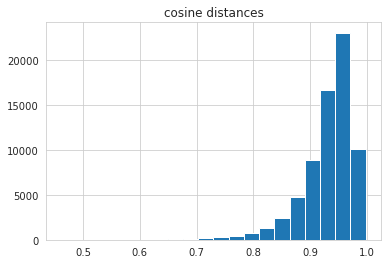

In [33]:
plt.title('cosine distances')
plt.hist(cosine_dists, bins=20)
plt.show()

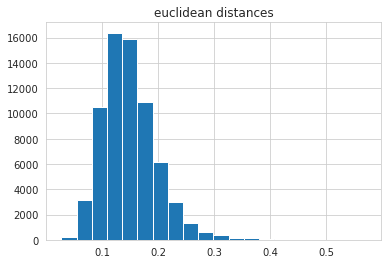

In [35]:
plt.title('euclidean distances')
plt.hist(euclidean_dists, bins=20)
plt.show()

### 5. dataset and dataloaders

In [49]:
sp = spm.SentencePieceProcessor(model_file='news10k.model')

In [50]:
class Dataset(TorchDataset):
    def __init__(self, articles, highlights):
        self.articles = articles
        self.highlights = highlights

    def __getitem__(self, index):
        article = self.articles[index]
        highlight = self.highlights[index]
        
        return (torch.tensor([1] + sp.encode(article) + [2], dtype=torch.long),
                torch.tensor([1] + sp.encode(highlight) + [2], dtype=torch.long))

    def __len__(self):
        return len(self.articles)

In [51]:
def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = length - vec.shape[dim]
    return torch.cat([vec, torch.zeros(pad_size, dtype=torch.long) + pad_symbol],
                     dim=dim)

class Padder:
    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def __call__(self, batch):
        max_article_len = max(map(lambda x: x[0].shape[self.dim], batch))
        max_highlight_len = max(map(lambda x: x[1].shape[self.dim], batch))
        batch = map(lambda x: (pad_tensor(x[0], max_article_len, self.dim, self.pad_symbol), 
                               pad_tensor(x[1], max_highlight_len, self.dim, self.pad_symbol)),
                    batch)
        batch = list(batch)
        xs = torch.stack(list(map(lambda x: x[0], batch)))
        ys = torch.stack(list(map(lambda x: x[1], batch)))
        return xs.permute(1, 0), ys.permute(1, 0)

In [52]:
train_dataset = Dataset(train_articles, train_highlights)
val_dataset = Dataset(val_articles, val_highlights)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [53]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([92, 128])
torch.Size([19, 128])


### 6. model architecture

In [64]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [65]:
vocab_size = 10000

In [66]:
writer = SummaryWriter()

In [69]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/gen_adv.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [71]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator3(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3, 3],
                     num_filters=200,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/dis2_adv.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

### 7. Topic difference for predictions

In [90]:
def tensor_to_text(t):
    if len(t.size()) == 3:
        t = t.permute(1, 0, 2)
        t = F.softmax(t, dim=2)
        tokens = torch.argmax(t, dim=2).detach().cpu().numpy().tolist()
        tokens = list(map(lambda x: [int(c) for c in x], tokens))
        return sp.decode(tokens)
    elif len(t.size()) == 2:
        tokens = t.permute(1, 0).detach().cpu().numpy().tolist()
        tokens = list(map(lambda x: [int(c) for c in x], tokens))
        return sp.decode(tokens)

In [94]:
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=False)

In [95]:
predicted = []
for i, batch in enumerate(train_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G(article, highlight, teacher_forcing_ratio=0.)
    predicted += tensor_to_text(preds)

In [100]:
%%time
predicted_words = list(sent_to_words(predicted))
bigram = gensim.models.Phrases(predicted_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[predicted_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[predicted_words[0]]])

# Remove Stop Words
data_words_nostops = remove_stopwords(predicted_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
predicted_corpus = [id2word.doc2bow(text) for text in texts]

['pakistani', 'helicopter', 'violates', 'indian', 'airspace', 'in', 'jammu_and_kashmir']
[['violate']]
CPU times: user 1min 22s, sys: 87.1 ms, total: 1min 22s
Wall time: 1min 22s


In [103]:
predicted_topics = [get_topic_vector(text) for text in predicted_corpus]
predicted_ohe = [get_ohe_topic_vector(text) for text in predicted_corpus]

cosine distances: mean 0.932, std 0.046
euclidean distances: mean 0.14800000190734863, std 0.04800000041723251


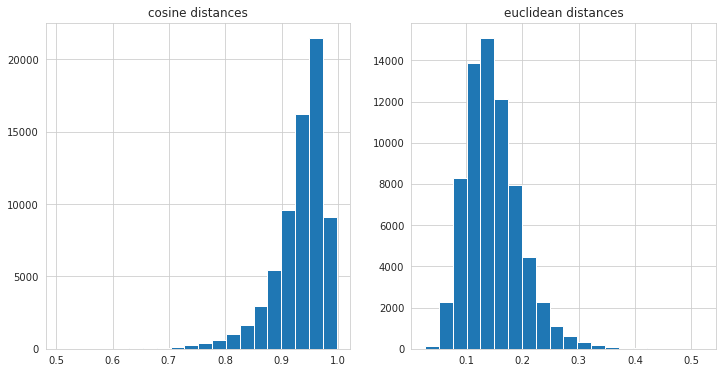

In [108]:
cosine_dists = []
euclidean_dists = []
for article_topic, predicted_topic in zip(article_topics, predicted_topics):
    cosine_dists.append(cosine_dist(article_topic, predicted_topic))
    euclidean_dists.append(euclidean_dist(article_topic, predicted_topic))
    
cosine_dists = np.array(cosine_dists)
euclidean_dists = np.array(euclidean_dists)

print(f'cosine distances: mean {round(np.mean(cosine_dists), 3)}, std {round(np.std(cosine_dists), 3)}')
print(f'euclidean distances: mean {round(np.mean(euclidean_dists), 3)}, std {round(np.std(euclidean_dists), 3)}')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('cosine distances')
plt.hist(cosine_dists, bins=20)

plt.subplot(122)
plt.title('euclidean distances')
plt.hist(euclidean_dists, bins=20)
plt.show()

cosine distances: mean 0.976, std 0.018
euclidean distances: mean 0.08299999684095383, std 0.032999999821186066


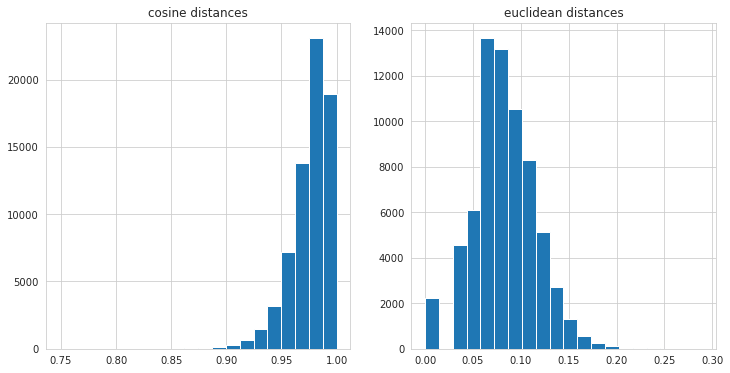

In [109]:
cosine_dists = []
euclidean_dists = []
for highlight_topic, predicted_topic in zip(highlight_topics, predicted_topics):
    cosine_dists.append(cosine_dist(highlight_topic, predicted_topic))
    euclidean_dists.append(euclidean_dist(highlight_topic, predicted_topic))
    
cosine_dists = np.array(cosine_dists)
euclidean_dists = np.array(euclidean_dists)

print(f'cosine distances: mean {round(np.mean(cosine_dists), 3)}, std {round(np.std(cosine_dists), 3)}')
print(f'euclidean distances: mean {round(np.mean(euclidean_dists), 3)}, std {round(np.std(euclidean_dists), 3)}')

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('cosine distances')
plt.hist(cosine_dists, bins=20)

plt.subplot(122)
plt.title('euclidean distances')
plt.hist(euclidean_dists, bins=20)
plt.show()

### 8. adversarial training with topic difference reward

In [41]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [116]:
n_epochs = 30

In [117]:
writer = SummaryWriter()

In [118]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [119]:
D.train()

CNNDiscriminator3(
  (embed): Embedding(10000, 256, padding_idx=0)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(3, 256), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=600, out_features=1, bias=True)
)

In [ ]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        # rewards = D(generated_highlight).squeeze(1)
        # rewards = 1 - rewards
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        pg_loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss/gen_pg_train', pg_loss.data.item(), iter_num)
        total_G_loss += pg_loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        # rewards = D(highlight.permute(1, 0)).squeeze(1)
        gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rewards = D(generated_highlight).squeeze(1)
        rewards = 1 - rewards
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        total_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Loss/gen_pg_val', total_loss / len(val_dataset), iter_num)
    
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    ind = sps.randint(0, out.size(1)).rvs(size=1)[0]
    print(f'predicted: {tensor_to_text(out)[ind]}')
    print(f'truth: {tensor_to_text(highlight)[ind]}')

539it [02:20,  3.82it/s]
0it [00:00, ?it/s]

epoch 0 G loss: 62.35173849710604
epoch 0 D loss: 0.002903600572744174


231it [00:23,  9.87it/s]
231it [00:13, 17.18it/s]
0it [00:00, ?it/s]

epoch 0 val loss: 6.240398753889086
predicted: never think about what i should have done in my films kajol
truth: i never think about what i should ve done differently kajol


539it [02:21,  3.80it/s]
1it [00:00,  9.96it/s]

epoch 1 G loss: 47.865445177563394
epoch 1 D loss: 0.0


231it [00:23,  9.84it/s]
231it [00:13, 17.19it/s]
0it [00:00, ?it/s]

epoch 1 val loss: 6.13325055379426
predicted: iit roorkee testing floating water water water water water
truth: iit roorkee tests device to generate electricity from river flow


539it [02:22,  3.80it/s]
0it [00:00, ?it/s]

epoch 2 G loss: 46.937514389516586
epoch 2 D loss: 0.0


231it [00:23,  9.84it/s]
231it [00:13, 17.16it/s]
0it [00:00, ?it/s]

epoch 2 val loss: 6.205351137395336
predicted: driver who did not not not students in bus driver
truth: suffering for no fault driver who let langur control steering


539it [02:22,  3.79it/s]
0it [00:00, ?it/s]

epoch 3 G loss: 45.95867564237907
epoch 3 D loss: 0.0


231it [00:23,  9.83it/s]
231it [00:13, 17.14it/s]
0it [00:00, ?it/s]

epoch 3 val loss: 6.177578165353401
predicted: airline bound flyer denied to board over flights
truth: air india refuses to let wheelchair bound passenger on plane


539it [02:21,  3.80it/s]
0it [00:00, ?it/s]

epoch 4 G loss: 45.33131635003527
epoch 4 D loss: 0.0


231it [00:23,  9.84it/s]
231it [00:13, 17.13it/s]
0it [00:00, ?it/s]

epoch 4 val loss: 6.187460463817743
predicted: google using us to improve battery life inroidroidroid
truth: google using ai to improve battery life on android phones


539it [02:22,  3.79it/s]
0it [00:00, ?it/s]

epoch 5 G loss: 44.97705843279724
epoch 5 D loss: 0.0


231it [00:23,  9.83it/s]
231it [00:13, 17.15it/s]
0it [00:00, ?it/s]

epoch 5 val loss: 6.194557842145965
predicted: in 92 cases are closer in mp cm cm chouhan chouhan
truth: daughters should be taught about good bad touch mp cm


539it [02:22,  3.78it/s]
0it [00:00, ?it/s]

epoch 6 G loss: 44.764794788072614
epoch 6 D loss: 0.0


231it [00:23,  9.82it/s]
231it [00:13, 17.11it/s]
0it [00:00, ?it/s]

epoch 6 val loss: 6.152247121803224
predicted: was threatened to change my birthdate girls in school school
truth: was threatened to change asaram rape victim s age principal


539it [02:22,  3.78it/s]
0it [00:00, ?it/s]

epoch 7 G loss: 44.29410306994785
epoch 7 D loss: 0.0


231it [00:23,  9.84it/s]
231it [00:13, 17.17it/s]
0it [00:00, ?it/s]

epoch 7 val loss: 6.206152853202232
predicted: nasa proposes sun cosmic magnifying glass
truth: nasa team proposes using sun as cosmic magnifying glass


539it [02:22,  3.79it/s]
0it [00:00, ?it/s]

epoch 8 G loss: 43.923672385221295
epoch 8 D loss: 3.4457376126998237e-09


231it [00:23,  9.82it/s]
231it [00:13, 17.14it/s]
0it [00:00, ?it/s]

epoch 8 val loss: 6.245768995208471
predicted: trump reveals social media firms wereencings
truth: social media giants are silencing millions of people trump


539it [02:22,  3.78it/s]
0it [00:00, ?it/s]

epoch 9 G loss: 43.52158483666964
epoch 9 D loss: 0.0007265699126851787


231it [00:23,  9.83it/s]
231it [00:13, 17.19it/s]
0it [00:00, ?it/s]

epoch 9 val loss: 6.216177083269972
predicted: delhi s  i ruled out of ipl 10 10 after 8 years
truth: delhi s last year top scorer quinton de kock out of ipl 2017


539it [02:22,  3.79it/s]
0it [00:00, ?it/s]

epoch 10 G loss: 43.5655945674883
epoch 10 D loss: 0.0


231it [00:23,  9.84it/s]
231it [00:13, 17.13it/s]
0it [00:00, ?it/s]

epoch 10 val loss: 6.232732881791732
predicted: iit roorkee testing floating devices from water water water
truth: iit roorkee tests device to generate electricity from river flow


539it [02:22,  3.78it/s]
0it [00:00, ?it/s]

epoch 11 G loss: 43.6210108687238
epoch 11 D loss: 0.0


231it [00:23,  9.84it/s]
231it [00:13, 17.17it/s]
0it [00:00, ?it/s]

epoch 11 val loss: 6.209147133182241
predicted: srikanth srikanth srikanth conferred with padma shri
truth: kidambi srikanth conferred with padma shri award


539it [02:22,  3.79it/s]
0it [00:00, ?it/s]

epoch 12 G loss: 42.87531956707005
epoch 12 D loss: 0.0


231it [00:23,  9.82it/s]
231it [00:13, 17.18it/s]
0it [00:00, ?it/s]

epoch 12 val loss: 6.245034063513745
predicted: solar storms to to hit earth sea in norway
truth: minor solar flare expected to hit earth today cause auroras


395it [01:44,  3.80it/s]

In [ ]:
# save_path = 'saved_models/dis2_adv.pth'
# torch.save(D.state_dict(), save_path)

# save_path = 'saved_models/gen_adv.pth'
# torch.save(G.state_dict(), save_path)